In [0]:
#https://www.tensorflow.org/tutorials/estimator/boosted_trees_model_understanding

In [2]:
from __future__ import absolute_import, division, print_function, unicode_literals

# TensorFlow and tf.keras
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf
from tensorflow import keras
import numpy as np

TensorFlow 2.x selected.


This seems to be inclined to learn how to interpret a Boosted Trees model both locally and globally and gain intution for how a Boosted Trees model fits a dataset. (It seems more theorical)


#How to interpret Boosted Trees models both locally and globally

Local interpretability refers to an understanding of a model’s predictions at the individual example level, while global interpretability refers to an understanding of the model as a whole. Such techniques can help machine learning (ML) practitioners detect bias and bugs during the model development stage.

For local interpretability, you will learn how to create and visualize per-instance contributions. To distinguish this from feature importances, we refer to these values as directional feature contributions (DFCs).

For global interpretability you will retrieve and visualize gain-based feature importances, permutation feature importances and also show aggregated DFCs.

#Load the titanic dataset

You will be using the titanic dataset, where the (rather morbid) goal is to predict passenger survival, given characteristics such as gender, age, class, etc.

In [0]:
import pandas as pd
from IPython.display import clear_output


In [0]:

# Load dataset.
dftrain = pd.read_csv('https://storage.googleapis.com/tf-datasets/titanic/train.csv')
dfeval = pd.read_csv('https://storage.googleapis.com/tf-datasets/titanic/eval.csv')
y_train = dftrain.pop('survived')
y_eval = dfeval.pop('survived')


In [0]:
import tensorflow as tf
tf.random.set_seed(123)


#Create feature columns, input_fn, and the train the estimator

#Preprocess the data

Create the feature columns, using the original numeric columns as is and one-hot-encoding categorical variables.

In [0]:
#Preprocess the data is: get column names, get vocabulary of features.
#for categorical make a one-hot, using the vocabulary.
#for numerical just transform it as a numeric column
fc = tf.feature_column
CATEGORICAL_COLUMNS = ['sex', 'n_siblings_spouses', 'parch', 'class', 'deck',
                       'embark_town', 'alone']
NUMERIC_COLUMNS = ['age', 'fare']

def one_hot_cat_column(feature_name, vocab):
  return fc.indicator_column(
      fc.categorical_column_with_vocabulary_list(feature_name,
                                                 vocab))
feature_columns = []
for feature_name in CATEGORICAL_COLUMNS:
  # Need to one-hot encode categorical features.
  vocabulary = dftrain[feature_name].unique()
  feature_columns.append(one_hot_cat_column(feature_name, vocabulary))

for feature_name in NUMERIC_COLUMNS:
  feature_columns.append(fc.numeric_column(feature_name,
                                           dtype=tf.float32))


#Build the input pipeline

Create the input functions using the `from_tensor_slices` method in the `tf.data` API to read in data directly from Pandas.

In [0]:
#Same thing, build the input by transforming it into a BatchDataset, 
  #Then shuffle it. NOTE: In evaluation dataset, there is no need to shuffle
# Use entire batch since this is such a small dataset.
NUM_EXAMPLES = len(y_train)

def make_input_fn(X, y, n_epochs=None, shuffle=True):
  def input_fn():
    dataset = tf.data.Dataset.from_tensor_slices((X.to_dict(orient='list'), y))
    if shuffle:
      dataset = dataset.shuffle(NUM_EXAMPLES)
    # For training, cycle thru dataset as many times as need (n_epochs=None).
    dataset = (dataset
      .repeat(n_epochs)
      .batch(NUM_EXAMPLES))
    return dataset
  return input_fn

# Training and evaluation input functions.
train_input_fn = make_input_fn(dftrain, y_train)
eval_input_fn = make_input_fn(dfeval, y_eval, shuffle=False, n_epochs=1)


#Train the model

In [8]:
#Here instead of just trainung the model with the default parameters, we are creating our own.
#I am not particularly sure what each parameter means. What are DFCs? - Directional feature contributions
params = {
  'n_trees': 50,
  'max_depth': 3,
  'n_batches_per_layer': 1,
  # You must enable center_bias = True to get DFCs. This will force the model to
  # make an initial prediction before using any features (e.g. use the mean of
  # the training labels for regression or log odds for classification when
  # using cross entropy loss).
  'center_bias': True
}

est = tf.estimator.BoostedTreesClassifier(feature_columns, **params)
# Train model.
est.train(train_input_fn, max_steps=100)

# Evaluation.
results = est.evaluate(eval_input_fn)
clear_output()
pd.Series(results).to_frame()

#Note, it seems that with this parameters we get a worse result than with the defaults

,0
accuracy,0.806818
accuracy_baseline,0.625000
auc,0.866606
auc_precision_recall,0.849128
average_loss,0.421549
label/mean,0.375000
loss,0.421549
precision,0.755319
prediction/mean,0.384944
recall,0.717172


NOTE: For performance reasons, when your data fits in memory, we recommend use the `boosted_trees_classifier_train_in_memory` function. However if training time is not of a concern or if you have a very large dataset and want to do distributed training, use the `tf.estimator.BoostedTrees` API shown above.

When using this method, you should not batch your input data, as the method operates on the entire dataset:


In [9]:
#example of in_memory training
in_memory_params = dict(params)
in_memory_params['n_batches_per_layer'] = 1
# In-memory input_fn does not use batching.
def make_inmemory_train_input_fn(X, y):
  y = np.expand_dims(y, axis=1)
  def input_fn():
    return dict(X), y
  return input_fn
train_input_fn = make_inmemory_train_input_fn(dftrain, y_train) #Te regresa un valor tipo function main, que usas para el train...

# Train the model.
est = tf.estimator.BoostedTreesClassifier(
    feature_columns, #las columnas
    train_in_memory=True, #Entrenar en memoria
    **in_memory_params) #los parametros en memoria 

est.train(train_input_fn)
print(est.evaluate(eval_input_fn))


INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/tmpnnvk5slu', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.


In [10]:
#Esta raro, porque input_fn te es esto: input_fnFromFunc = dict(dftrain), np.expand_dims(y_train, axis=1)
#y regresa un tuple de los dos diccionarios. (dftrain, y_train)
def input_fn(X,y):
  return dict(X), y
infnfuncreturn = input_fn(dict(dftrain), np.expand_dims(y_train, axis=1))
infnfuncreturn

#Pero si haces esto, que literal solo es poner la función make_inmemory_train_input_fn te regresa el valor como una funcion
#Le puedes cambiar el nombre y la goma, pero si le agregas otra linea, lo que pasa es que te regresa el valor como una función del nombre de la más alta
def another_instance_of_the_in_fn(X,y):
  def make_inmemory_train_input_fn0():
    def input_fn0():
      return dict(X), y
    return input_fn0
  return make_inmemory_train_input_fn0

train_input_fn_fullfunc = another_instance_of_the_in_fn(dftrain, np.expand_dims(y_train, axis=1))
train_input_fn_fullfunc

<function __main__.another_instance_of_the_in_fn.<locals>.make_inmemory_train_input_fn0>

#Model interpretation and plotting

In [0]:
import matplotlib.pyplot as plt
import seaborn as sns
sns_colors = sns.color_palette('colorblind')


#Local interpretability

Next you will output the directional feature contributions (DFCs) to explain individual predictions using the approach outlined in Palczewska et al and by Saabas in Interpreting Random Forests (this method is also available in scikit-learn for Random Forests in the `treeinterpreter` package). The DFCs are generated with:

`pred_dicts = list(est.experimental_predict_with_explanations(pred_input_fn))`

(Note: The method is named experimental as we may modify the API before dropping the experimental prefix.)

In [12]:
pred_dicts = list(est.experimental_predict_with_explanations(eval_input_fn))


INFO:tensorflow:Using config: {'_model_dir': '/tmp/tmpnnvk5slu', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tm

In [13]:
# Create DFC Pandas dataframe.
labels = y_eval.values
probs = pd.Series([pred['probabilities'][1] for pred in pred_dicts])
df_dfc = pd.DataFrame([pred['dfc'] for pred in pred_dicts])
df_dfc.describe().T
#A nice property of DFCs is that the sum of the contributions + the bias is equal to the prediction for a given example.
#In the table the values are probably the odds of each prediction?

,count,mean,std,min,25%,50%,75%,max
age,264.0,-0.023851,0.095522,-0.154286,-0.076392,-0.057281,0.009408,0.541436
sex,264.0,0.007242,0.110388,-0.123509,-0.074560,-0.073093,0.139799,0.182828
class,264.0,0.016631,0.093480,-0.065638,-0.046510,-0.045238,0.038365,0.236259
deck,264.0,-0.016809,0.031755,-0.086020,-0.041980,-0.029283,0.003319,0.187737
embark_town,264.0,-0.006789,0.028007,-0.053620,-0.014970,-0.013391,-0.003095,0.070267
fare,264.0,0.020249,0.088010,-0.308154,-0.028543,-0.008702,0.057093,0.228394
n_siblings_spouses,264.0,0.002551,0.028782,-0.177096,0.002736,0.003991,0.006956,0.135561
parch,264.0,-0.000049,0.009230,-0.075935,0.000389,0.000483,0.000871,0.050035
alone,264.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [14]:
# Sum of DFCs + bias == probabality.
bias = pred_dicts[0]['bias'] #Bias is equal in every dictionary
dfc_prob = df_dfc.sum(axis=1) + bias #Basically we are telling it to sum all the values in the row. + bias
np.testing.assert_almost_equal(dfc_prob.values,
                               probs.values)

dfc_prob #I belive this is basically the probability the passenger has to survive,
#In our model we have a treshold of when we decide the cutoff of saying if it survived or not
#Related to the ROC curve

0      0.124405
1      0.366700
2      0.807849
3      0.777052
4      0.171857
         ...   
259    0.867226
260    0.088293
261    0.283923
262    0.119505
263    0.541999
Length: 264, dtype: float64

In [0]:
#Plot DFCs for an individual passenger. 
#Let's make the plot nice by color coding based on the contributions' directionality and add the feature values on figure.
# Boilerplate code for plotting :)
#To be honest i did not pay much attention to this code scince its mostly seaborn modifications
def _get_color(value):
    """To make positive DFCs plot green, negative DFCs plot red."""
    green, red = sns.color_palette()[2:4]
    if value >= 0: return green
    return red

def _add_feature_values(feature_values, ax):
    """Display feature's values on left of plot."""
    x_coord = ax.get_xlim()[0]
    OFFSET = 0.15
    for y_coord, (feat_name, feat_val) in enumerate(feature_values.items()):
        t = plt.text(x_coord, y_coord - OFFSET, '{}'.format(feat_val), size=12)
        t.set_bbox(dict(facecolor='white', alpha=0.5))
    from matplotlib.font_manager import FontProperties
    font = FontProperties()
    font.set_weight('bold')
    t = plt.text(x_coord, y_coord + 1 - OFFSET, 'feature\nvalue',
    fontproperties=font, size=12)

def plot_example(example):
  TOP_N = 8 # View top 8 features.
  sorted_ix = example.abs().sort_values()[-TOP_N:].index  # Sort by magnitude.
  example = example[sorted_ix]
  colors = example.map(_get_color).tolist()
  ax = example.to_frame().plot(kind='barh',
                          color=[colors],
                          legend=None,
                          alpha=0.75,
                          figsize=(10,6))
  ax.grid(False, axis='y')
  ax.set_yticklabels(ax.get_yticklabels(), size=14)

  # Add feature values.
  _add_feature_values(dfeval.iloc[ID][sorted_ix], ax)
  return ax

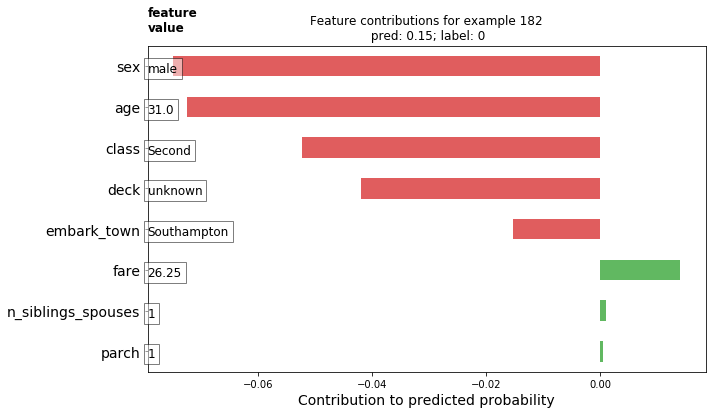

In [16]:
# Plot results.
ID = 182
example = df_dfc.iloc[ID]  # Choose ith example from evaluation set.
TOP_N = 8  # View top 8 features.
sorted_ix = example.abs().sort_values()[-TOP_N:].index
ax = plot_example(example)
ax.set_title('Feature contributions for example {}\n pred: {:1.2f}; label: {}'.format(ID, probs[ID], labels[ID]))
ax.set_xlabel('Contribution to predicted probability', size=14)
plt.show()


The larger magnitude contributions have a larger impact on the model's prediction. Negative contributions indicate the feature value for this given example reduced the model's prediction, while positive values contribute an increase in the prediction.

(in this case the .15 is the sum of every probability + the bias)

In [0]:
#You can also plot the example's DFCs compare with the entire distribution using a voilin plot.
# Boilerplate plotting code.
def dist_violin_plot(df_dfc, ID):
  # Initialize plot.
  fig, ax = plt.subplots(1, 1, figsize=(10, 6))

  # Create example dataframe.
  TOP_N = 8  # View top 8 features.
  example = df_dfc.iloc[ID]
  ix = example.abs().sort_values()[-TOP_N:].index
  example = example[ix]
  example_df = example.to_frame(name='dfc')

  # Add contributions of entire distribution.
  parts=ax.violinplot([df_dfc[w] for w in ix],
                 vert=False,
                 showextrema=False,
                 widths=0.7,
                 positions=np.arange(len(ix)))
  face_color = sns_colors[0]
  alpha = 0.15
  for pc in parts['bodies']:
      pc.set_facecolor(face_color)
      pc.set_alpha(alpha)

  # Add feature values.
  _add_feature_values(dfeval.iloc[ID][sorted_ix], ax)

  # Add local contributions.
  ax.scatter(example,
              np.arange(example.shape[0]),
              color=sns.color_palette()[2],
              s=100,
              marker="s",
              label='contributions for example')

  # Legend
  # Proxy plot, to show violinplot dist on legend.
  ax.plot([0,0], [1,1], label='eval set contributions\ndistributions',
          color=face_color, alpha=alpha, linewidth=10)
  legend = ax.legend(loc='lower right', shadow=True, fontsize='x-large',
                     frameon=True)
  legend.get_frame().set_facecolor('white')

  # Format plot.
  ax.set_yticks(np.arange(example.shape[0]))
  ax.set_yticklabels(example.index)
  ax.grid(False, axis='y')
  ax.set_xlabel('Contribution to predicted probability', size=14)


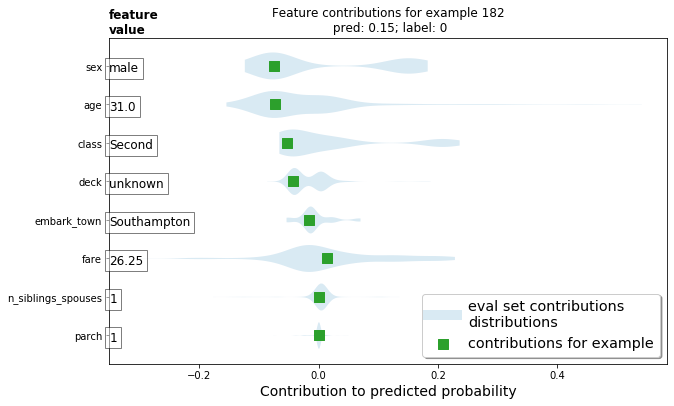

In [19]:
#plot the example
dist_violin_plot(df_dfc, ID)
plt.title('Feature contributions for example {}\n pred: {:1.2f}; label: {}'.format(ID, probs[ID], labels[ID]))
plt.show()


Finally, third-party tools, such as LIME and shap, can also help understand individual predictions for a model.

(it seems we will not cover those)

#Global feature importances

Additionally, you might want to understand the model as a whole, rather than studying individual predictions. Below, you will compute and use:

    Gain-based feature importances using est.experimental_feature_importances
    Permutation importances
    Aggregate DFCs using est.experimental_predict_with_explanations

Gain-based feature importances measure the loss change when splitting on a particular feature, while permutation feature importances are computed by evaluating model performance on the evaluation set by shuffling each feature one-by-one and attributing the change in model performance to the shuffled feature.

In general, permutation feature importance are preferred to gain-based feature importance, though both methods can be unreliable in situations where potential predictor variables vary in their scale of measurement or their number of categories and when features are correlated (source). Check out this article for an in-depth overview and great discussion on different feature importance types.

#Gain-based feature importances

Gain-based feature importances are built into the TensorFlow Boosted Trees estimators using `est.experimental_feature_importances`.

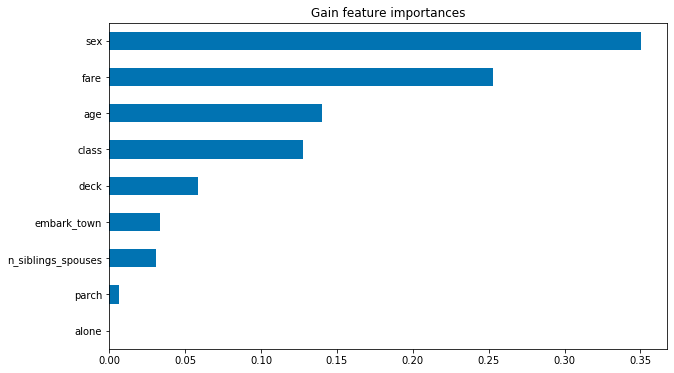

In [29]:
importances = est.experimental_feature_importances(normalize=True) #create the importances, based on the already trained model
#It gives the importance of each feature
df_imp = pd.Series(importances) #creates a pandas series from the importances ¿dictionary?

# Visualize importances.
N = 9 #number of features to visualize (max 9, more will do nothing, less will only show the N most important) 
ax = (df_imp.iloc[0:N][::-1]
    .plot(kind='barh',
          color=sns_colors[0],
          title='Gain feature importances',
          figsize=(10, 6)))
ax.grid(False, axis='y')



#Average absolute DFCs

You can also average the absolute values of DFCs to understand impact at a global level.

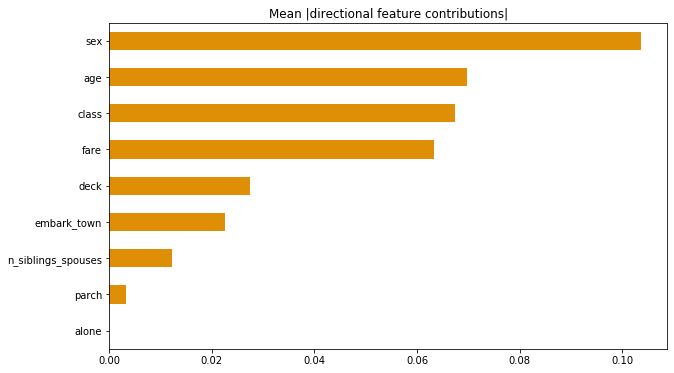

In [37]:
# Plot.
dfc_mean = df_dfc.abs().mean() #sacas el promedio ABSOLUTO de cada uno (quitas negativos)
N = 9
sorted_ix = dfc_mean.abs().sort_values()[-N:].index  # Average and sort by absolute.
ax = dfc_mean[sorted_ix].plot(kind='barh', #build the plot
                       color=sns_colors[1],
                       title='Mean |directional feature contributions|',
                       figsize=(10, 6))
ax.grid(False, axis='y')


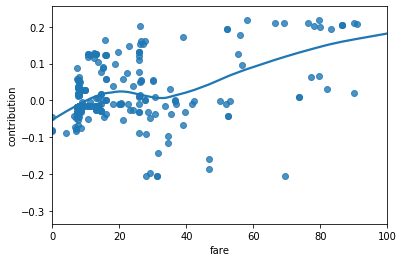

In [38]:
#You can also see how DFCs vary as a feature value varies.
FEATURE = 'fare'
feature = pd.Series(df_dfc[FEATURE].values, index=dfeval[FEATURE].values).sort_index() #lists the feature (the fare), vs the contribution to survival
#you can see how higher fare contributes to survival
ax = sns.regplot(feature.index.values, feature.values, lowess=True)
ax.set_ylabel('contribution')
ax.set_xlabel(FEATURE)
ax.set_xlim(0, 100)
plt.show()


#Permutation feature importance


I think permutation is when you swap a value (eg, sex) and leave everything else the same, that way you can see how a specific feature changes the probabilities according to your model

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2020-01-21T19:10:33Z
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmpnnvk5slu/model.ckpt-153
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Inference Time : 0.56267s
INFO:tensorflow:Finished evaluation at 2020-01-21-19:10:34
INFO:tensorflow:Saving dict for global step 153: accuracy = 0.8030303, accuracy_baseline = 0.625, auc = 0.8679216, auc_precision_recall = 0.8527449, average_loss = 0.4203342, global_step = 153, label/mean = 0.375, loss = 0.4203342, precision = 0.7473684, prediction/mean = 0.38673538, recall = 0.7171717
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 153: /tmp/tmpnnvk5slu/model.ckpt-153
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2020-01-21T19:10:35Z
INFO:tensorflow:Graph was finaliz

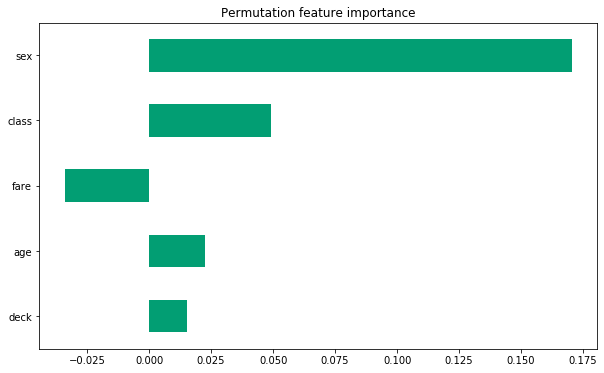

In [46]:
#Nota: los resultados salen diferentes cada vez que se corre por lo mismo que usas una permutación al azar
def permutation_importances(est, X_eval, y_eval, metric, features): #regresa un array con las importances de cada valor pero usando permutación
    """Column by column, shuffle values and observe effect on eval set.

    source: http://explained.ai/rf-importance/index.html   <long ass article
    A similar approach can be done during training. See "Drop-column importance"
    in the above article."""
    baseline = metric(est, X_eval, y_eval) #the accuracy metric without any permutation
    imp = []
    for col in features:
        save = X_eval[col].copy() #passes the column to save
        X_eval[col] = np.random.permutation(X_eval[col]) #creates a random permutation, and overwrties the current values
        m = metric(est, X_eval, y_eval) #using the accuray_metric function, it evalues the accuracu with the est.evaluate method
        X_eval[col] = save #return the column to its original state
        imp.append(baseline - m) #substract our metric with permutation to the baseline
    return np.array(imp)

def accuracy_metric(est, X, y):
    """TensorFlow estimator accuracy."""
    eval_input_fn = make_input_fn(X,
                                  y=y,
                                  shuffle=False,
                                  n_epochs=1)
    return est.evaluate(input_fn=eval_input_fn)['accuracy']


features = CATEGORICAL_COLUMNS + NUMERIC_COLUMNS
importances = permutation_importances(est, dfeval, y_eval, accuracy_metric,
                                      features)
df_imp = pd.Series(importances, index=features)

sorted_ix = df_imp.abs().sort_values().index
ax = df_imp[sorted_ix][-5:].plot(kind='barh', color=sns_colors[2], figsize=(10, 6))
ax.grid(False, axis='y')
ax.set_title('Permutation feature importance')
plt.show()


#Visualizing model fitting

Lets first simulate/create training data using the following formula:

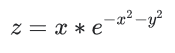

Where (z) is the dependent variable you are trying to predict and (x) and (y) are the features.

In [0]:
from numpy.random import uniform, seed

# Create fake data
seed(0)
npts = 5000
x = uniform(-2, 2, npts)
y = uniform(-2, 2, npts)
z = x*np.exp(-x**2 - y**2)


In [54]:
# random arrays of 5000 points that follow the formula
z

array([ 0.14148831,  0.21306852,  0.01767334, ..., -0.09606164,
       -0.00913236,  0.01314796])

In [0]:
# Prep data for training.
df = pd.DataFrame({'x': x, 'y': y, 'z': z}) #making the data into a pd dataframe

xi = np.linspace(-2.0, 2.0, 200), #transformin the data into a numpy array, but only of 200 datapoints, returns that ammount of evenly spaced samples
yi = np.linspace(-2.1, 2.1, 210),
xi,yi = np.meshgrid(xi, yi) #but when you do this they become 210 samples, with 200 datapoints each(for the xi, im not sure where the other 10 come from)

df_predict = pd.DataFrame({
    'x' : xi.flatten(),
    'y' : yi.flatten(),
}) #it makes an 200*210 (42000) flat array of x and y 
predict_shape = xi.shape #the shape of xi, which is the predict shape??

In [79]:
print(len(xi[0]))
print(len(xi))
#df_predict.iloc[14000] gets row 14000
df_predict
predict_shape

200
210


(210, 200)

In [0]:
def plot_contour(x, y, z, **kwargs):
  # Grid the data.
  plt.figure(figsize=(10, 8))
  # Contour the gridded data, plotting dots at the nonuniform data points.
  CS = plt.contour(x, y, z, 15, linewidths=0.5, colors='k')
  CS = plt.contourf(x, y, z, 15,
                    vmax=abs(zi).max(), vmin=-abs(zi).max(), cmap='RdBu_r')
  plt.colorbar()  # Draw colorbar.
  # Plot data points.
  plt.xlim(-2, 2)
  plt.ylim(-2, 2)


In [0]:
#You can visualize the function. Redder colors correspond to larger function values.
#does not work because griddata wont import...
"""
from matplotlib.mlab import griddata
zi = griddata(x, y, z, xi, yi, interp='linear')
plot_contour(xi, yi, zi)
plt.scatter(df.x, df.y, marker='.')
plt.title('Contour on training data')
plt.show()
"""
#it showed a contour plot
wjqpowjqpdhp = 1313209123810923 #just so the comment is not shown

In [96]:
fc = [tf.feature_column.numeric_column('x'),
      tf.feature_column.numeric_column('y')] #create an array of features: numeric columns, 
fc

[NumericColumn(key='x', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None),
 NumericColumn(key='y', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None)]

In [0]:
#This would give the predictions after the model is trained 
def predict(est):
  """Predictions from a given estimator."""
  predict_input_fn = lambda: tf.data.Dataset.from_tensors(dict(df_predict)) #df_predict is the dic of 42000 x and y
  preds = np.array([p['predictions'][0] for p in est.predict(predict_input_fn)])
  return preds.reshape(predict_shape)


In [102]:
#First let's try to fit a linear model to the data.

train_input_fn = make_input_fn(df, df.z)
est = tf.estimator.LinearRegressor(fc)
est.train(train_input_fn, max_steps=500);


INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/tmpao4ug4ck', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}
INFO:tensorflow:Calling model_fn.
Instructions for updating:
Please use `layer.add_weight` method instead.
Instructio

In [107]:
#plot_contour(xi, yi, predict(est)) #but does not work because cant import griddata
predict(est).shape #Gives a 210,200 shape
#It's not a very good fit. Next let's try to fit a GBDT model to it and try to understand how the model fits the function.


INFO:tensorflow:Calling model_fn.

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmpao4ug4ck/model.ckpt-500
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


(210, 200)

In [110]:
n_trees = 36 #@param {type: "slider", min: 1, max: 80, step: 1}

est = tf.estimator.BoostedTreesRegressor(fc, n_batches_per_layer=1, n_trees=n_trees) #fc are the input numeric columns
est.train(train_input_fn, max_steps=500) #train the model
#train_input_fn is a call to the function that creates a batchdataset
#Note: increasing the number of trees improves the accuracy
#At least in this case


INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/tmptsw86eyy', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.


In [112]:
train_input_fn

<function __main__.make_input_fn.<locals>.input_fn>

#Conclusion

In this tutorial you learned how to interpret Boosted Trees models using directional feature contributions and feature importance techniques. These techniques provide insight into how the features impact a model's predictions. Finally, you also gained intution for how a Boosted Tree model fits a complex function by viewing the decision surface for several models.

In [0]:
#Note, it seems that estimators are models that are already made in only tensorflow, and keras does not do anything in this environment.